##### Corrected_GRACE[GRACE-FO] = Uncorrected + Degree1 - GIA + GAD - Mascon_C20 + SLR_C20 [- Mascon_C30 + SLR_C30]

1. Convert mascon grid (in m EWH) into spherical harmonics using pyshtools (specifically expand.SHExpandDH)
2. Divide coefficients by the Fn in table 1 for EWH to convert to dimensionless stokes
3. Multiply dimensionless stokes coefficients by Fn for viscoelastic vertical deformation according to Purcell at el (2011)
4. We can then evaluate 3 at any lat,lon point using pyshtools.expand.MakeGridPoint

In [1]:
import numpy as np # used for numeric calculations and arrays
from scipy.interpolate import griddata # used for interpolating onto a grid
import netCDF4 as nc # used to open NetCDF4 files
from netCDF4 import Dataset # used to open NetCDF4 files
import cartopy.crs as ccrs # used to plot
import matplotlib.pyplot as plt # used to plot
from datetime import datetime, date, timedelta # used to convert time to decimal year
import pyshtools as pysh # used for spherical harmonics

In [2]:
grid_l3_mascons = Dataset('C:/Users/rubym/OneDrive - Australian National University/Honours/Python Drafts/GRACE/ANU_mascons_RL02_2002-2023_grid.nc') # open the NetCDF4 dataset

grid_l3_mascons_lat = grid_l3_mascons['lat'][:] # set latitude column
grid_l3_mascons_lon = grid_l3_mascons['lon'][:] # set longitude column
grid_l3_mascons_time = grid_l3_mascons['time'][:] # set time column
grid_l3_mascons_lwe = grid_l3_mascons['lwe_thickness'][:]/100 # liquid water equivalent converted from cm to m

grid_l3_mascons_lwe_unmasked = grid_l3_mascons_lwe.data # remove mask

nlat = len(grid_l3_mascons_lat) # find number of latitudes
nlon = len(grid_l3_mascons_lon) # find number of longitudes
ntime = len(grid_l3_mascons_time) # find number of timesteps

In [3]:
GIA = Dataset('C:/Users/rubym/OneDrive - Australian National University/Honours/Python Drafts/GRACE/ANU_mascons_RL02_2002-2023_GIA_lwe_thickness.nc') # open the GIA corrections

grid_l3_mascons_GIA_lwe = GIA['GIA_lwe_thickness'][:].data/100 # GIA correction liquid water equivalent converted from cm to m

uncorrected_GIA_grid_l3_mascons_lwe = grid_l3_mascons_GIA_lwe + grid_l3_mascons_lwe_unmasked
#corrected = uncorrected - GIA

In [4]:
d0 = date(2002, 1, 1) # first date of GRACE data
dec_yr = np.zeros(ntime) # set decimal year array the same length as the number of GRACE timesteps
 
for i in range (ntime): # for each time
    d1 = d0 + timedelta(days=int(grid_l3_mascons_time[i])) # add time offset to starting time
    days_in_year = date(d1.year, 12, 31).strftime("%j") # find days in the current year
    dec_yr[i] = d1.year + (int(d1.strftime("%j"))/int(days_in_year)) # calculate decimal year

In [5]:
n = 720

latitudes = np.linspace(90, -90, n,endpoint=False) # create Driscoll-Healey grid
longitudes = np.linspace(0, 360, 2*n, endpoint=False)

In [6]:
# below is the original code to find the uncorrected for GIA mascons on a Driscoll-Healey grid

#DH_grid_uncorrected_GIA_mascons = np.empty((224, latitudes.size, longitudes.size))  # create empty array (time, lat, lon)

#original_lon_grid, original_lat_grid = np.meshgrid(grid_l3_mascons_lon, grid_l3_mascons_lat) # create meshgrid of GRACE longitudes and latitudes
#lon_grid, lat_grid = np.meshgrid(longitudes, latitudes) # create meshgrid of Driscoll-Healey grid longitudes and latitudes

#original_points = np.column_stack((original_lon_grid.flatten(), original_lat_grid.flatten())) # flatten to 1D and stack
#target_points = np.column_stack((lon_grid.flatten(), lat_grid.flatten())) # flatten to 1D and stack

#for t in range(224): # for each timestep
    #values = uncorrected_GIA_grid_l3_mascons_lwe[t, :, :].flatten() # flatten the GRACE values
    #interpolated_values = griddata(original_points, values, target_points, method='nearest') # interpolate GRACE points onto Driscoll-Healey grid
    #DH_grid_uncorrected_GIA_mascons[t] = interpolated_values.reshape(latitudes.size, longitudes.size) # append these to new array with time step

In [7]:
#np.save("DH_grid_uncorrected_GIA_mascons", DH_grid_uncorrected_GIA_mascons)
DH_grid_uncorrected_GIA_mascons = np.load("DH_grid_uncorrected_GIA_mascons.npy") # load in the previous work

In [8]:
SH_lwe_list_deg90 = [] # create a list for spherical harmonics degree 90

for t in range(ntime): # for each timestep
    SH_lwe_t_deg90 = pysh.expand.SHExpandDH(DH_grid_uncorrected_GIA_mascons[t,:,:], sampling=2, lmax_calc=89) # expand the GRACE points on the DH grid to spherical harmonics
    SH_lwe_list_deg90.append(SH_lwe_t_deg90) # add SH to list
SH_lwe_array_deg90 = np.array(SH_lwe_list_deg90 # turn SH list to array

# as above for 180 degrees:

SH_lwe_list_deg180 = []

for t in range(ntime):
    SH_lwe_t_deg180 = pysh.expand.SHExpandDH(DH_grid_uncorrected_GIA_mascons[t,:,:], sampling=2, lmax_calc=179)
    SH_lwe_list_deg180.append(SH_lwe_t_deg180)
SH_lwe_array_deg180 = np.array(SH_lwe_list_deg180)

In [9]:
Love_numbers = np.loadtxt('C:/Users/rubym/OneDrive - Australian National University/Honours/Python Drafts/GRACE/Load_Love2_CM.dat') # load in Love number file

degree = Love_numbers[0:180,0] # set degree
h_array = Love_numbers[0:180,1] # set h
l_array = Love_numbers[0:180,2] # set l
k_array = Love_numbers[0:180,3] # set k

higher_deg_Love_ratios = [73.195, 74.475, 75.768, 77.05, 78.35, 79.642, 80.947, 82.264, 83.577, 84.915,  86.229, 87.571, 88.892, 90.244, 91.604, 92.943, 94.319, 95.705, 97.071, 98.442, 99.858, 101.24, 102.67, 104.07, 105.51, 106.91, 108.34, 109.82, 111.25, 112.71,  114.2,  115.67,  117.18, 118.65,  120.14, 121.66,  123.2, 124.74, 126.29,  127.85, 129.41, 130.95, 132.57,  134.17, 135.84, 137.36, 139.06,  140.7, 142.29, 144.04, 145.72,  147.3, 149.05,  150.69,  152.5, 154.18, 155.88,  157.74,  159.43,  161.3, 162.97,  164.81, 166.61,  168.6, 170.32, 172.21, 174.04,  176.05,  177.98, 179.82,  181.83, 183.73, 185.5, 187.43, 189.54,  191.5, 193.63,  195.58, 197.7, 199.6, 201.68, 203.93, 205.93,208.1, 209.97,  212.49,  214.71, 216.58,  218.61,  220.8,223.16, 225.7,  227.83, 230.11,  232.57,  234.53,  236.63,  238.9, 241.32,  243.93, 245.93, 248.88, 251.2, 253.67, 255.42, 258.21,  260.25,  263.39, 265.73,  268.22, 270.88, 272.62, 275.58,  277.58, 280.87,  283.17, 285.59,  288.17, 290.88,  293.76] # Purcell et al 2011
higher_deg_Love_ratios = np.asarray(higher_deg_Love_ratios)
# create the higher degree love number ratios according to Purcell et al 2011 averaged Love number ratios.
viscoelastic_vert_factor = 1.1677*degree[0:60] - 0.5233 # use the relationship from Purcell et al 2011 for the first 60 degrees

viscoelastic_vert_factor = np.hstack([viscoelastic_vert_factor, higher_deg_Love_ratios]) # stack the columns of the Purcell et al 2011 relationship and the averaged higher degree ratios

In [10]:
def get_conv_factor(fname, degmax=180): # create conversion factor

    rad_e = 6371008.771415 # radius Earth
    rho_e = 5514.0 # average density of Earth
    rho_w = 1000.0 # density of water

    k_array[0] = 0.0 # set lower degrees
    k_array[1] = 0.021 # center of mass to center of figure (see Swenson et al. 2008/Blewitt et al. 2003)
    
    # conversion factor from SH to EWH in m
    
    Conv = (rad_e * rho_e) / (3 * rho_w) * (2 * degree + 1) / (1 + k_array) # EWH from Wahr et al 1998
    return Conv

In [11]:
Conv = get_conv_factor(SH_lwe_array_deg90, degmax=90) # get conversion factor for deg 90 SH
Conv = Conv[0:90]
SH_Stokes_deg90 = np.zeros_like(SH_lwe_array_deg90) # create array of zeros for storing Stokes coefficients

SH_Stokes_deg90[:, :, 0, 0] = 0 # set the degree 0 (zonal term) coefficients to 0

for t in range(224): # for each time
    SH_lwe_array_deg90[t, 0, 1:, :] /= Conv[1:, None] # normalise
    SH_Stokes_deg90[t, 0, 1:, :] = SH_lwe_array_deg90[t, 0, 1:, :]
    
    SH_lwe_array_deg90[t, 1, 1:, :] /= Conv[1:, None] # normalise
    SH_Stokes_deg90[t, 1, 1:, :] = SH_lwe_array_deg90[t, 1, 1:, :]


# as above for degree 180: 
Conv = get_conv_factor(SH_lwe_array_deg180, degmax=180)
Conv = Conv[0:180]
SH_Stokes_deg180 = np.zeros_like(SH_lwe_array_deg180)

SH_Stokes_deg180[:, :, 0, 0] = 0

for t in range(224):
    SH_lwe_array_deg180[t, 0, 1:, :] /= Conv[1:, None]
    SH_Stokes_deg180[t, 0, 1:, :] = SH_lwe_array_deg180[t, 0, 1:, :]
    
    SH_lwe_array_deg180[t, 1, 1:, :] /= Conv[1:, None]
    SH_Stokes_deg180[t, 1, 1:, :] = SH_lwe_array_deg180[t, 1, 1:, :]

In [16]:
viscoelastic_vert_deg90 = viscoelastic_vert_factor[0:90] * SH_Stokes_deg90 # convert to viscoelastic vertical
viscoelastic_vert_deg180 = viscoelastic_vert_factor[0:180] * SH_Stokes_deg180 # convert to viscoelastic vertical

In [17]:
viscoelastic_vert_SH_deg90 = []

for t in range(224):
    sh_coeff = pysh.SHCoeffs.from_array(viscoelastic_vert_deg90[t, :, :])
    viscoelastic_vert_SH_deg90.append(sh_coeff)


viscoelastic_vert_SH_deg180 = []

for t in range(224):
    sh_coeff = pysh.SHCoeffs.from_array(viscoelastic_vert_deg180[t, :, :])
    viscoelastic_vert_SH_deg180.append(sh_coeff)

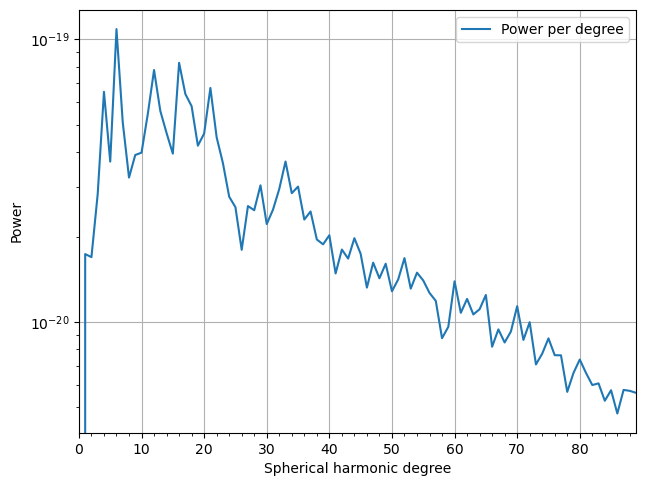

In [25]:
fig, ax = viscoelastic_vert_SH_deg90[0].plot_spectrum() # plot spectrum of degrees

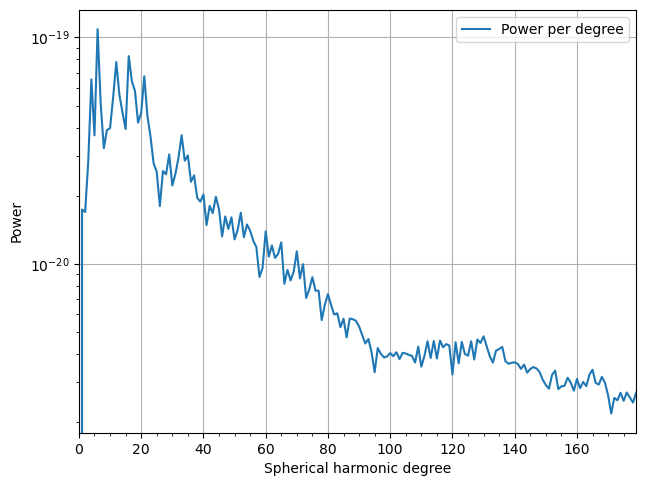

In [19]:
fig, ax = viscoelastic_vert_SH_deg180[0].plot_spectrum()